In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import scTRS.method as md
import matplotlib.pyplot as plt
import scTRS.util as util

In [2]:
adata = sc.read_h5ad("data/kang2018.h5ad")
adata = adata[adata.obs["multiplets"] != "doublet"]
adata.layers["counts"] = adata.X.copy()

# normalize
median_umi = np.median(adata.X.sum(axis=1).A1)
sc.pp.normalize_total(adata, target_sum=median_umi)
sc.pp.log1p(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [3]:
GS_FILE = "/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs"
df_gs = pd.read_csv(GS_FILE, sep='\t')
df_gs.index = df_gs['TRAIT']

trait_list = ["UKB_460K.body_HEIGHTz", "PASS_Lupus", "PASS_Rheumatoid_Arthritis", "UKB_460K.blood_RED_COUNT", "UKB_460K.blood_MONOCYTE_COUNT"]
df_gs = df_gs[df_gs.TRAIT.isin(trait_list)]

In [4]:
df_res_dict = dict()
for trait in df_gs.index:
    print(trait)
    gene_list = df_gs.loc[trait,'GENESET'].split(',')
    df_res = md.score_cell(adata, gene_list, n_ctrl=500, 
                           return_ctrl_raw_score=False, 
                           return_ctrl_norm_score=True,
                           verbose=False)
    df_res_dict[trait] = df_res

PASS_Rheumatoid_Arthritis
PASS_Lupus
UKB_460K.blood_RED_COUNT
UKB_460K.blood_MONOCYTE_COUNT
UKB_460K.body_HEIGHTz


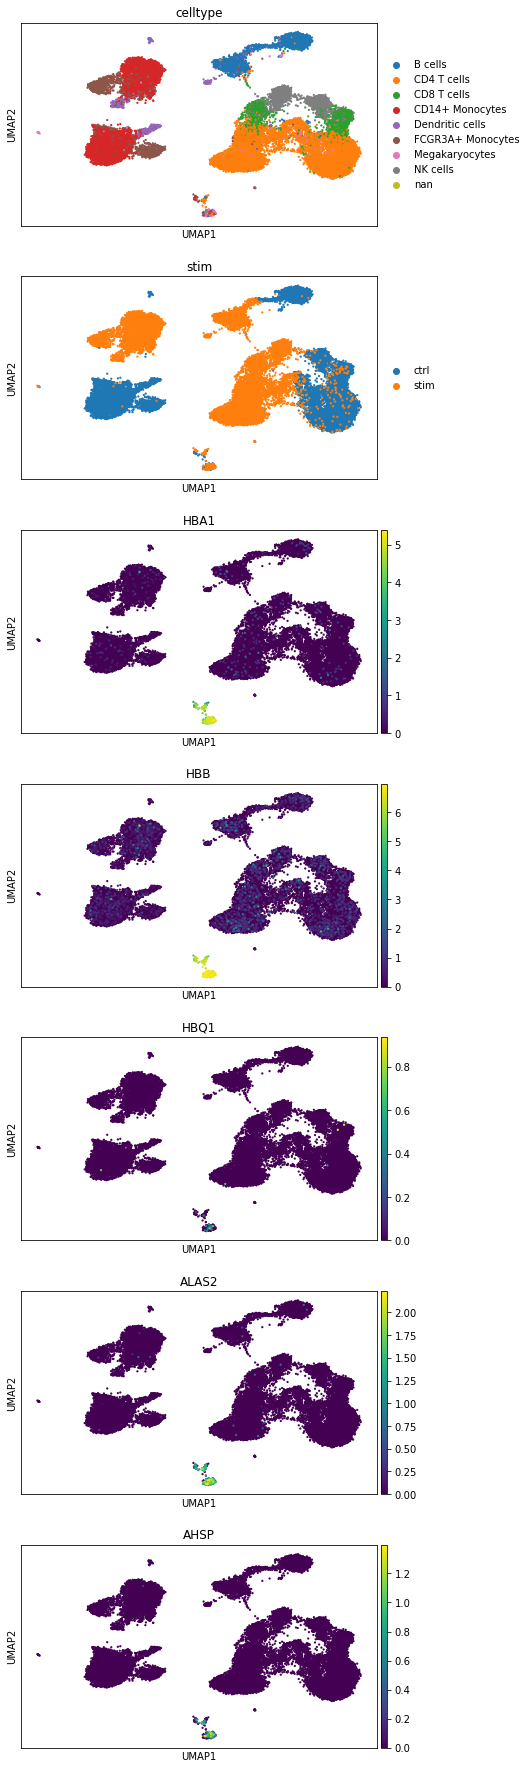

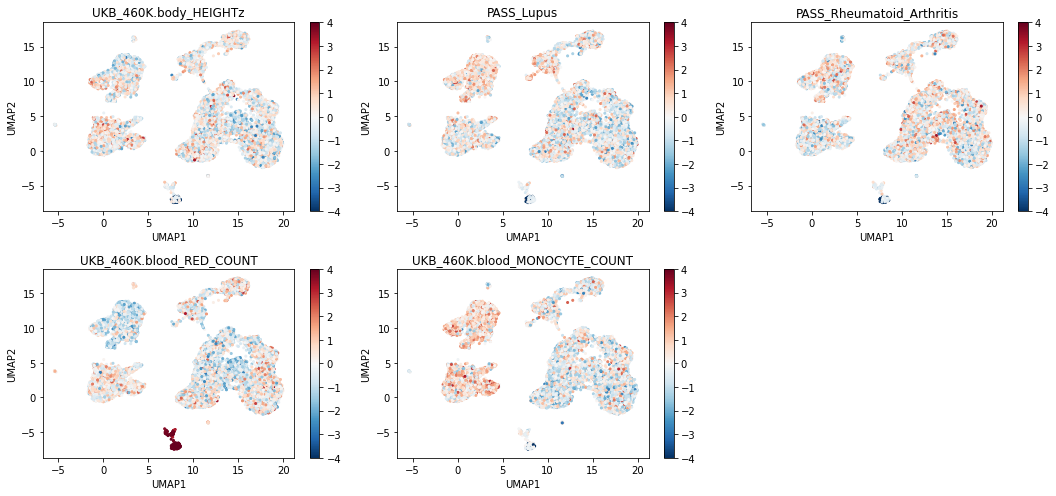

In [14]:
zsc_dict = dict()
for trait in trait_list:
    zsc_dict[trait] = df_res_dict[trait]["zscore"].reindex(adata.obs.index).values
score_index = adata.obs.index
erythrocytes_marker_genes = ["HBA1", "HBB", "HBQ1", "ALAS2", "AHSP"]
util.plot_score_umap(zsc_dict, score_index, adata, n_col=3, umap_color=["celltype", "stim"] + erythrocytes_marker_genes) 

# A plot for each trait, stratify by cell types, stim v.s. control

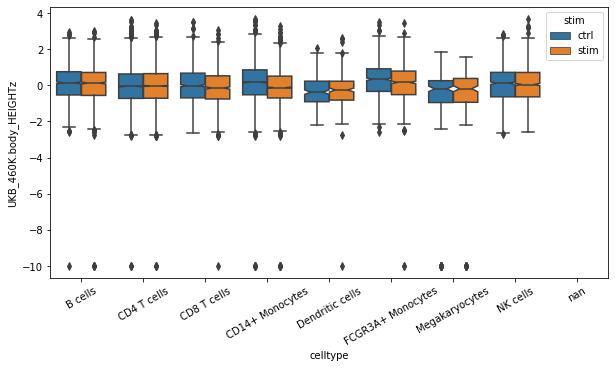

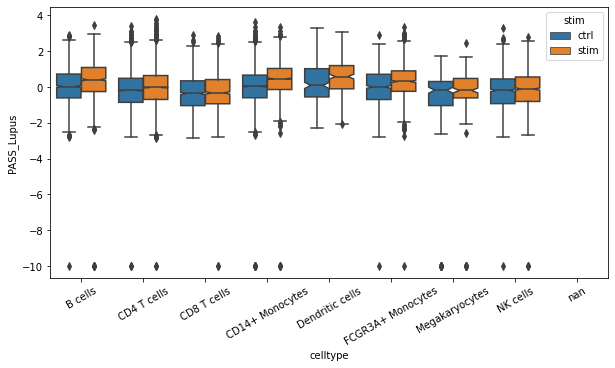

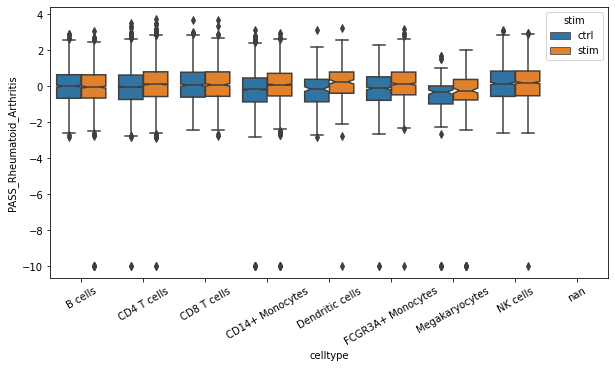

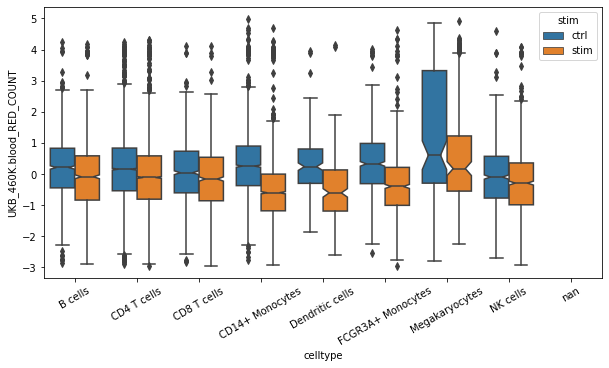

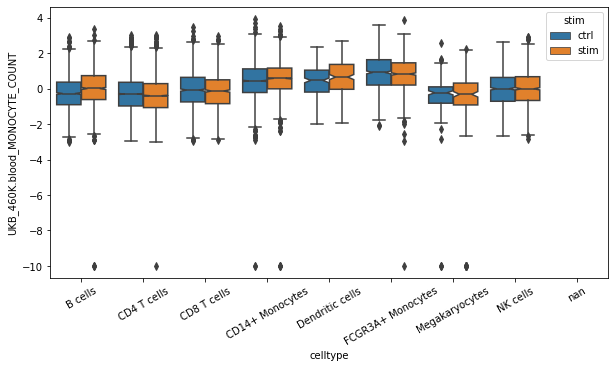

In [66]:
import seaborn as sns
for trait in trait_list:
    adata.obs[trait] = df_res_dict[trait]["zscore"].reindex(adata.obs.index).values
    x = "celltype"
    hue = "stim"
    df = adata.obs[adata.obs["celltype"] != 'nan'].copy()
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(data=df, x=x, y=trait, hue=hue, notch=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)